In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import qutip as qt 
from CD_control_optimization.batch_optimizer import BatchOptimizer
from CD_control_optimization.optimization_analysis import OptimizationAnalysis, OptimizationSweepsAnalysis
from CD_control_optimization.optimization_sweeps import OptimizationSweeps
import matplotlib.pyplot as plt
from tensorflow.python.client import device_lib
device_lib.list_local_devices()


Need tf version 2.3.0 or later. Using tensorflow version: 2.3.1



[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 11419283681162395597, name: "/device:XLA_CPU:0"
 device_type: "XLA_CPU"
 memory_limit: 17179869184
 locality {
 }
 incarnation: 14579947961388737491
 physical_device_desc: "device: XLA_CPU device"]

In [2]:
N = 60
N_blocks = 6
fock = 3
N_multistart = 10
epochs = 100
use_displacements = False
no_CD_end = False
initial_states = [qt.tensor(qt.basis(2,0),qt.basis(N,0))]
#target_states = [qt.tensor(qt.basis(2,0), c.zero_logical)]
target_states = [qt.tensor(qt.basis(2,0),qt.basis(N,fock))]
#target_states = [qt.tensor(qt.basis(2,0), (qt.coherent(N,alpha) + qt.coherent(N,-alpha)).unit())]
desired_epsilon = 1e-3
term_fid = 1-desired_epsilon
dfid_stop = 1e-8
beta_scale = 2.0
alpha_scale = 0.5
name='Fock 3'

In [3]:
opt = BatchOptimizer(initial_states=initial_states, target_states=target_states, N_blocks=N_blocks,term_fid = term_fid,
N_multistart=N_multistart, use_displacements=use_displacements, no_CD_end=no_CD_end, dfid_stop=dfid_stop, name=name, epochs=epochs, beta_scale=beta_scale, alpha_scale=alpha_scale,
fock=fock)

In [4]:
opt.print_info()

optimization_type: state transfer
N_multistart: 10
N_blocks: 6
term_fid: 0.999
dfid_stop: 1e-08
no_CD_end: False
name: Fock 3
learning_rate: 0.01
epoch_size: 10
epochs: 100
beta_scale: 2.0
alpha_scale: 0.5
use_displacements: False
comment: 
fock: 3
N_cav: 60
filename: Fock 3.h5

Best circuit parameters found:
betas:         [ 1.0241 -1.41513j -0.32489+0.57632j -0.28636-1.72178j -0.46895-0.1634j
  1.96791-0.3311j   0.51353-0.61138j]
alphas:        [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
phis (deg):    [   0.       178.71849 -130.32558   63.48731 -110.71501 -167.3173 ]
thetas (deg):  [  87.85006   83.63583  -68.59583   25.62058 -101.95396   10.26629]
Max Fidelity:  0.154058




In [5]:
opt.optimize()

Start time: 2020-10-22 02:21:53 PM
 Epoch: 13 / 100 Max Fid: 0.956135 Avg Fid: 0.726815 Max dFid: 0.093509 Avg dFid: 0.022816 Elapsed time: 0:00:19.413599 Remaing time: 0:02:09.921781

KeyboardInterrupt: 

In [6]:
opt.print_info()

optimization_type: state transfer
N_multistart: 10
N_blocks: 6
term_fid: 0.999
dfid_stop: 1e-08
no_CD_end: False
name: Fock 3
learning_rate: 0.01
epoch_size: 10
epochs: 100
beta_scale: 2.0
alpha_scale: 0.5
use_displacements: False
comment: 
fock: 3
N_cav: 60
filename: Fock 3.h5

Best circuit parameters found:
betas:         [-2.89636+0.26808j  0.93497+0.15216j  1.11494+1.30966j -0.65116+1.26832j
  0.51879+0.04813j -0.00143-0.08961j]
alphas:        [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
phis (deg):    [  0.       39.77945 179.44205   4.50747   1.53004 269.70035]
thetas (deg):  [ -90.57654  159.92195   68.40418 -132.57047  270.7059   -88.57894]
Max Fidelity:  0.956851




In [11]:
filename = "Fock 3.h5"
ana = OptimizationAnalysis(filename)

In [13]:
ana.target_state()

Quantum object: dims = [[2, 60], [1, 1]], shape = (120, 1), type = ket
Qobj data =
[[0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]]

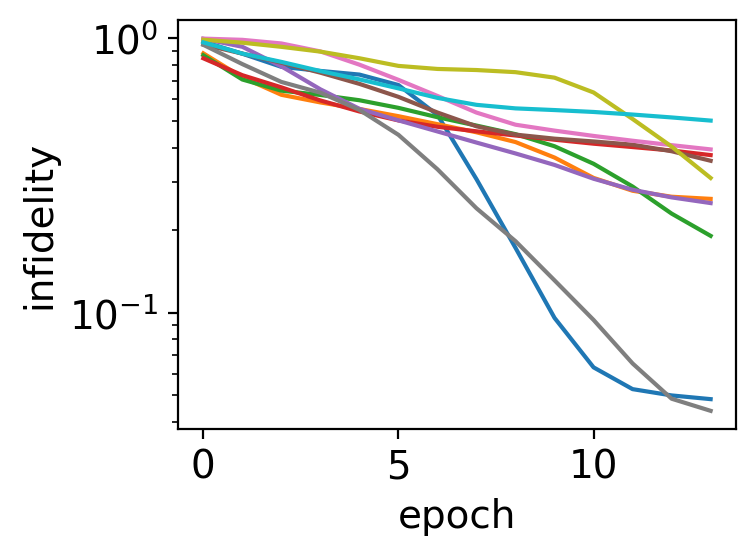

In [14]:
ana.plot_fidelities()

In [ ]:
sweeper = OptimizationSweeps(opt_object=opt)

In [ ]:
sweeper.N_blocks_sweep(min_N_blocks=2, max_N_blocks=10, terminate=True)

In [ ]:
#filename = 'Cat Creation.h5'
#filename = "C:\\Users\\Alec\\Desktop\\Fock 1.h5"
filename = "Fock 3.h5"
sweep_analysis = OptimizationSweepsAnalysis(filename=filename)

In [ ]:
sweep_analysis.sweep_names

In [ ]:
sweep_analysis._load_data()

In [ ]:
sweep_analysis.plot_sweep_fidelities()

In [ ]:
s = timestamps[0]
if len(timestamps) > 1:
    for t in timestamps:
        s =s + ',' + t
print(s)

In [ ]:
a = 'c:/a/test.h5'

In [ ]:
a.split(".")

In [ ]:
opt.optimize()

In [ ]:
c = opt.best_circuit()

In [ ]:
c['betas']

In [ ]:
opt.best_fidelity()

In [ ]:
opt.print_info()

In [ ]:
opt.modify_parameters(N_blocks = 10)

In [ ]:
tf.is_tensor(qt.create(10))

In [ ]:
#filename = 'fock 3.h5'
analysis = OptimizationAnalysis(filename=filename)
#bs = analysis.betas()

In [ ]:
analysis.timestamps

In [ ]:
analysis.data[analysis.timestamps[-1]]['betas'][-1].shape

In [ ]:
analysis.print_info()

In [ ]:
analysis.plot_fidelities()

In [ ]:
analysis.plot_mag_betas()

In [ ]:
analysis.plot_phase_betas()

In [ ]:
analysis.plot_mag_alphas()

In [ ]:
analysis.plot_phase_alphas()

In [ ]:
analysis.

In [ ]:
analysis.plot_average_magnitude_alpha()

In [ ]:
analysis.plot_average_magnitude_beta()

In [ ]:
analysis.data[analysis.timestamps[-1]]

In [ ]:
plt.figure(figsize=(8,6))
if len(all_fids.shape)>1:
    for fids in all_fids:
        plt.semilogy(1-fids)
else:
    plt.semilogy(1-all_fids)
plt.xlabel('epoch')
plt.ylabel('infidelity')
plt.title("100x batch optimization")

In [ ]:
opt.print_info()

In [ ]:
betas, alphas, phis, thetas = opt.get_numpy_vars()

In [ ]:
betas.T.shape

In [ ]:
fids = opt.batch_state_fidelities(opt.betas_rho, opt.betas_angle, opt.alphas_rho, opt.alphas_angle, opt.phis, opt.thetas)

In [ ]:
max_idx = tf.argmax(fids)[0,0].numpy()
max_idx

In [ ]:
fids[max_idx]

In [ ]:
betas[max_idx]

In [ ]:
with tf.device("XLA_GPU:0"):
    a = tf.constant(1.0)

In [ ]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

In [ ]:
tf.config.list_physical_devices()

In [ ]:
chi_ab = 2*np.pi*1e-9*10

In [ ]:
chi_ab

In [ ]:
nbar = 1/(4*chi_ab*1000)
nbar

In [ ]:
np.sqrt(nbar)

In [ ]:
np.sqrt(400.0)

In [ ]:
import h5py

In [ ]:
data = np.array([1.0,2.0,3.0])
with h5py.File('test.h5', "w") as f:
    fidelities = f.create_dataset("fidelities", data = data, maxshape=(None,))

In [ ]:
with h5py.File('test.h5', "a") as f:
    f['fidelities'].resize(4, axis=0)
    f['fidelities'][-1] = 4.0

In [ ]:
fs_MHz = np.linspace(0,0.2,201)
omegas_MRadps = 2*np.pi*fs_MHz
tau_us = 10
argument = omegas_MRadps*tau_us/2/np.pi
y = np.sinc(argument)**2


In [ ]:
plt.figure(figsize=(4,3),dpi=200)
plt.plot(fs_MHz*1e3, y, label='tau=10us')
plt.xlabel('KHz')
plt.ylabel('F')
plt.legend(frameon=False)